# UMAPs Neurips samples, NK cells

In this notebook different markers to identify NK cell subpopulations are tested. Markers are collected from Melsen et al., paper (2022). RNA and corresponding surface markers are shown when available. Protein expression levels within a cell are normalized using the centered-log ratio (CLR) transformation. UMAPs are generated from latent space, CLR normalized protein counts or RNA expression. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
import umap

from ridgeplot import ridgeplot

import warnings

warnings.filterwarnings('ignore')



Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
#Neurips
adata_neurips = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_neurips_norm_outer.h5ad')

In [3]:
#To find gene names

result = [i for i in adata_neurips.var_names if i.startswith('TC')]
print(result)

['TC2N', 'TCAF1', 'TCAF2', 'TCAIM', 'TCAP', 'TCEA1', 'TCEA2', 'TCEA3', 'TCEAL1', 'TCEAL2', 'TCEAL3', 'TCEAL4', 'TCEAL5', 'TCEAL7', 'TCEAL8', 'TCEAL9', 'TCEANC', 'TCEANC2', 'TCEB1', 'TCEB2', 'TCEB3', 'TCEB3-AS1', 'TCERG1', 'TCF12', 'TCF15', 'TCF19', 'TCF20', 'TCF23', 'TCF25', 'TCF3', 'TCF4', 'TCF4-AS2', 'TCF7', 'TCF7L1', 'TCF7L2', 'TCFL5', 'TCHH', 'TCHP', 'TCIRG1', 'TCL1A', 'TCL1B', 'TCL6', 'TCN2', 'TCOF1', 'TCP1', 'TCP10L', 'TCP11', 'TCP11L1', 'TCP11L2', 'TCTA', 'TCTE1', 'TCTE3', 'TCTEX1D1', 'TCTEX1D2', 'TCTEX1D4', 'TCTN1', 'TCTN2', 'TCTN3']


In [4]:
#Both NK cell types selected

neurips_nk = adata_neurips[(adata_neurips.obs['cell_type'] == "NK") | (adata_neurips.obs['cell_type'] == "NK CD158e1+")]

In [5]:
neurips_nk

View of AnnData object with n_obs × n_vars = 7388 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [6]:
neurips_nk_prot=neurips_nk.obsm['protein_expression_clr_neurips']

In [7]:
#To exclude columns that contain only zeros

neurips_nk_prot = pd.DataFrame(neurips_nk_prot)
neurips_nk_prot != 0
(neurips_nk_prot != 0).any(axis=0)
neurips_nk_prot.loc[:, (neurips_nk_prot != 0).any(axis=0)]
neurips_nk_prot = neurips_nk_prot.loc[:, (neurips_nk_prot != 0).any(axis=0)]

In [8]:
samples=adata_neurips.obs['POOL'].unique().tolist()

In [9]:
#selecting one sample from Neurips

eg=adata_neurips[adata_neurips.obs['POOL'] == "s4d1"]


In [10]:
eg

View of AnnData object with n_obs × n_vars = 4885 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [11]:
prot=eg.obsm['protein_expression_clr_neurips']

In [12]:
#some proteins and genes have same names, here _prot added after protein names
prot=prot.rename(columns={'CD2': 'CD2_prot', 'CX3CR1': 'CX3CR1_prot', 'CD226':'CD226_prot', 'TIGIT':'TIGIT_prot', 'CD27':'CD27_prot', 'CD38': 'CD38_prot', 'CD224': 'CD224_prot', 'CD7': 'CD7_prot', 'CD44': 'CD44_prot', 'CD34': 'CD34_prot','CD5': 'CD5_prot'})


In [13]:
#adding protein information to obs

a = eg.obs
b = prot

adata_eg=pd.concat([a, b], axis=1)
eg.obs=adata_eg


In [14]:
eg

AnnData object with n_obs × n_vars = 4885 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44_prot', 'CD14', 'CD16', 'CD25',

In [15]:
#selecting NK cells, gd T cells and ILCs

sample_nk = eg[(eg.obs['cell_type'] == "NK") | (eg.obs['cell_type'] == "NK CD158e1+")]   


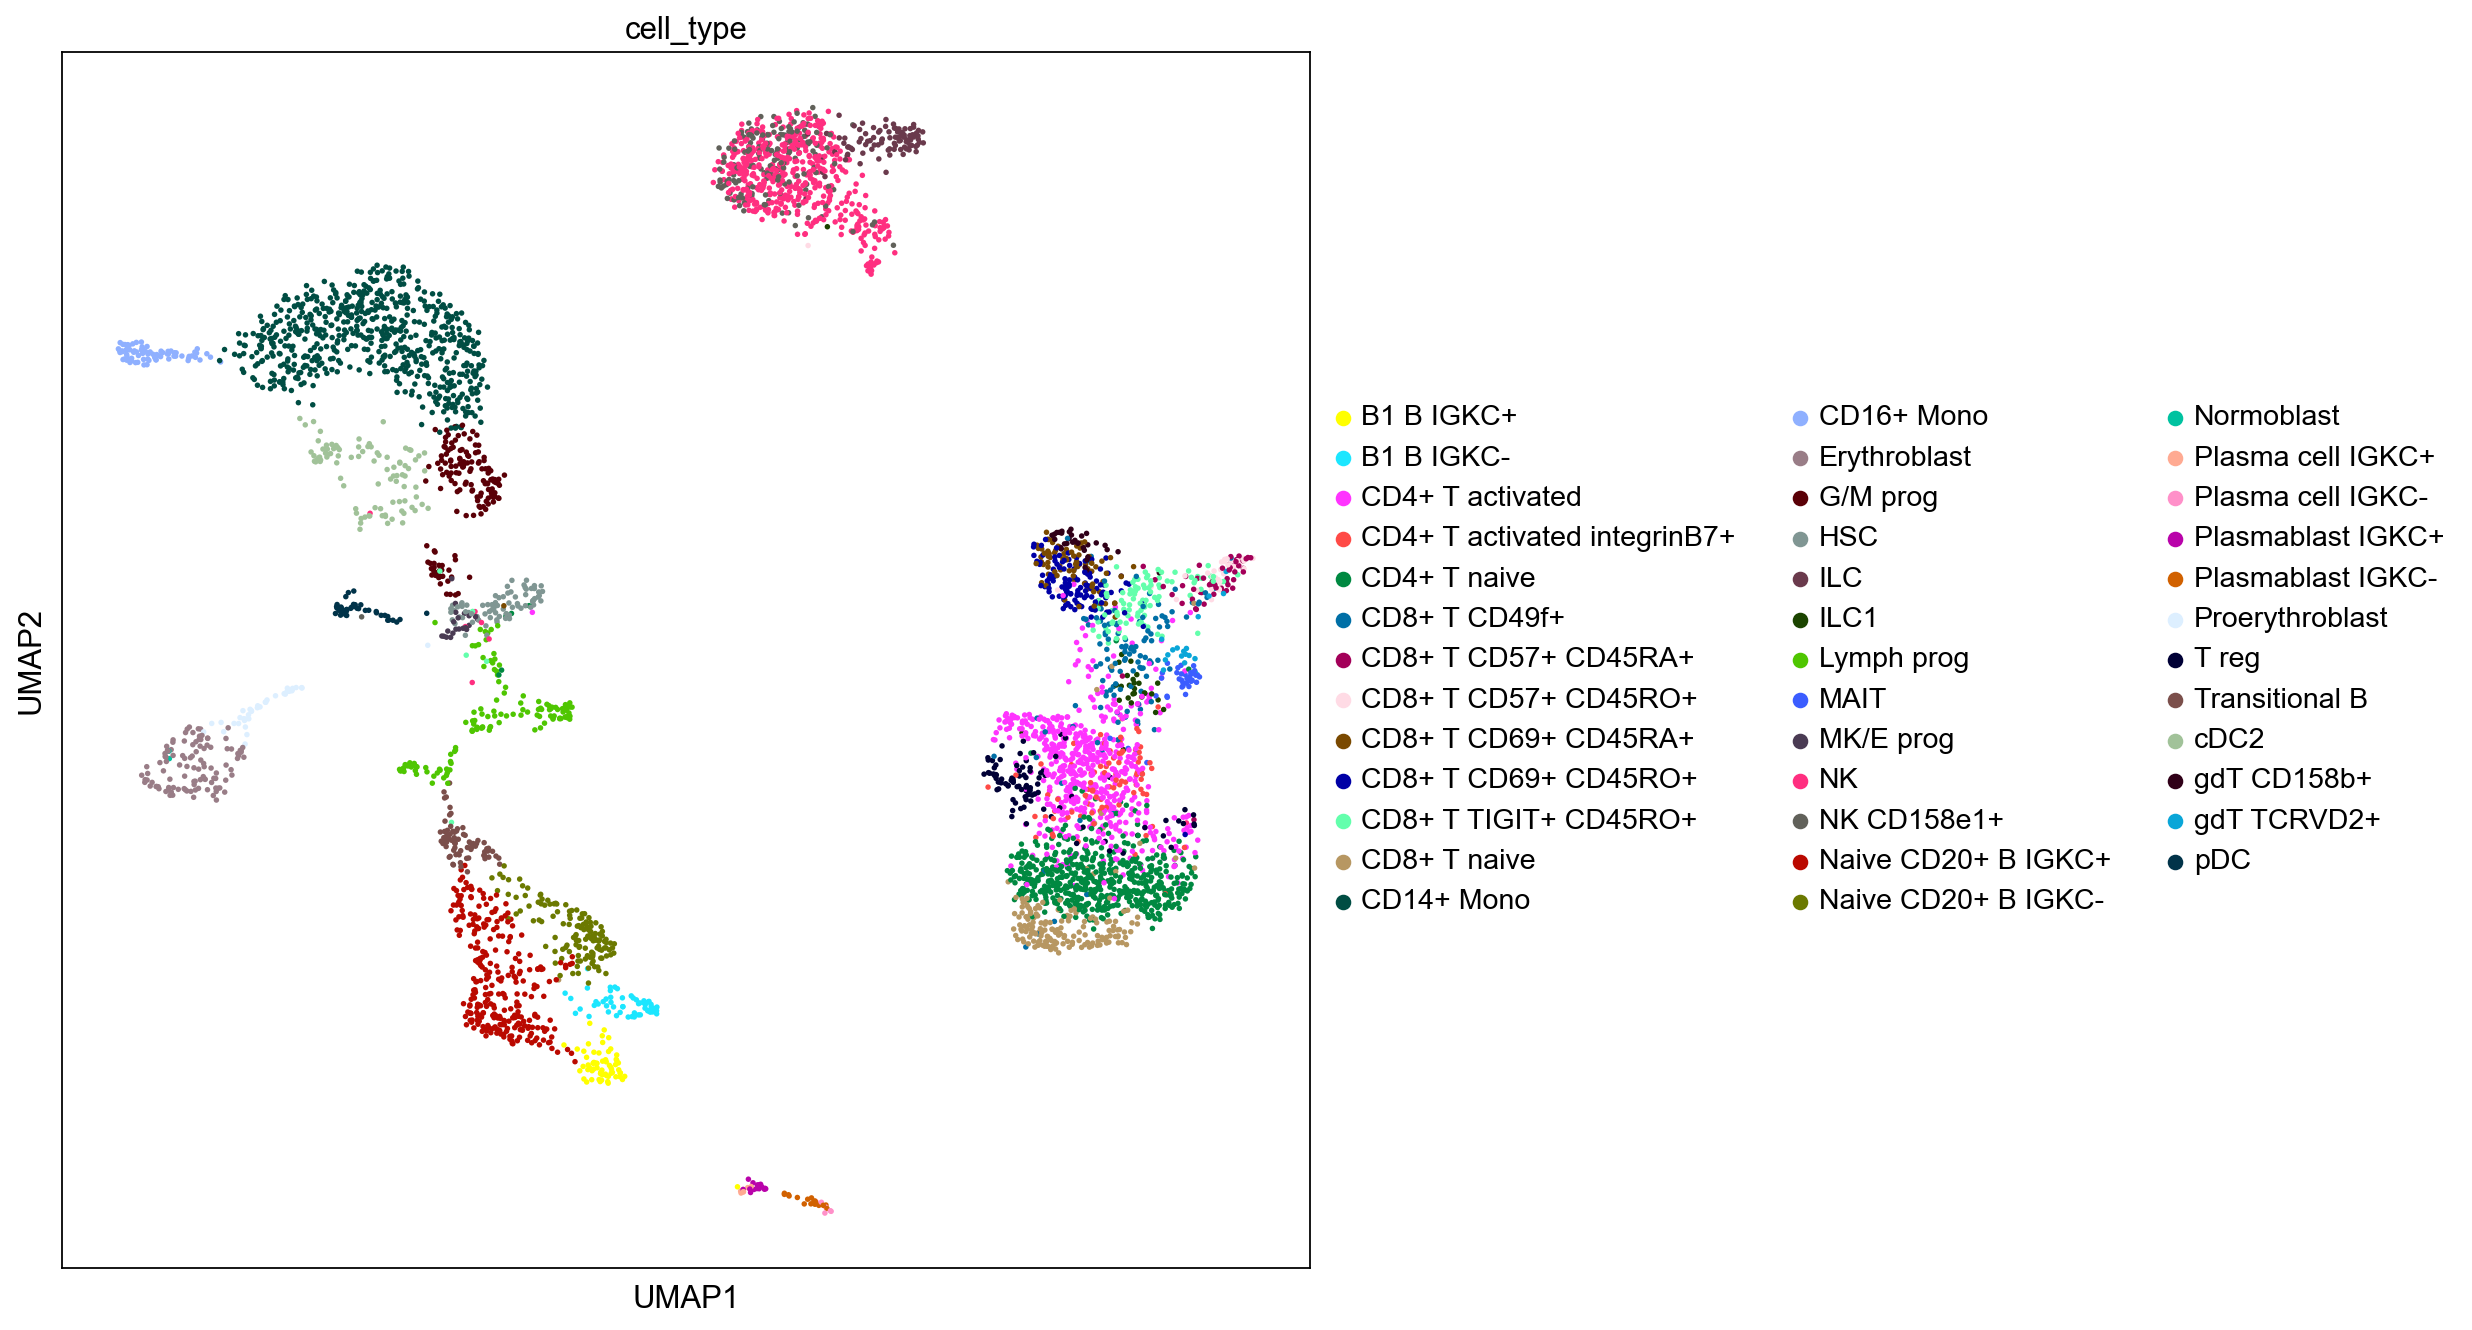

In [16]:
#Only selected sample

sc.set_figure_params(figsize=(10, 10))


sc.pl.umap(eg, color = ['cell_type'], color_map = 'viridis')

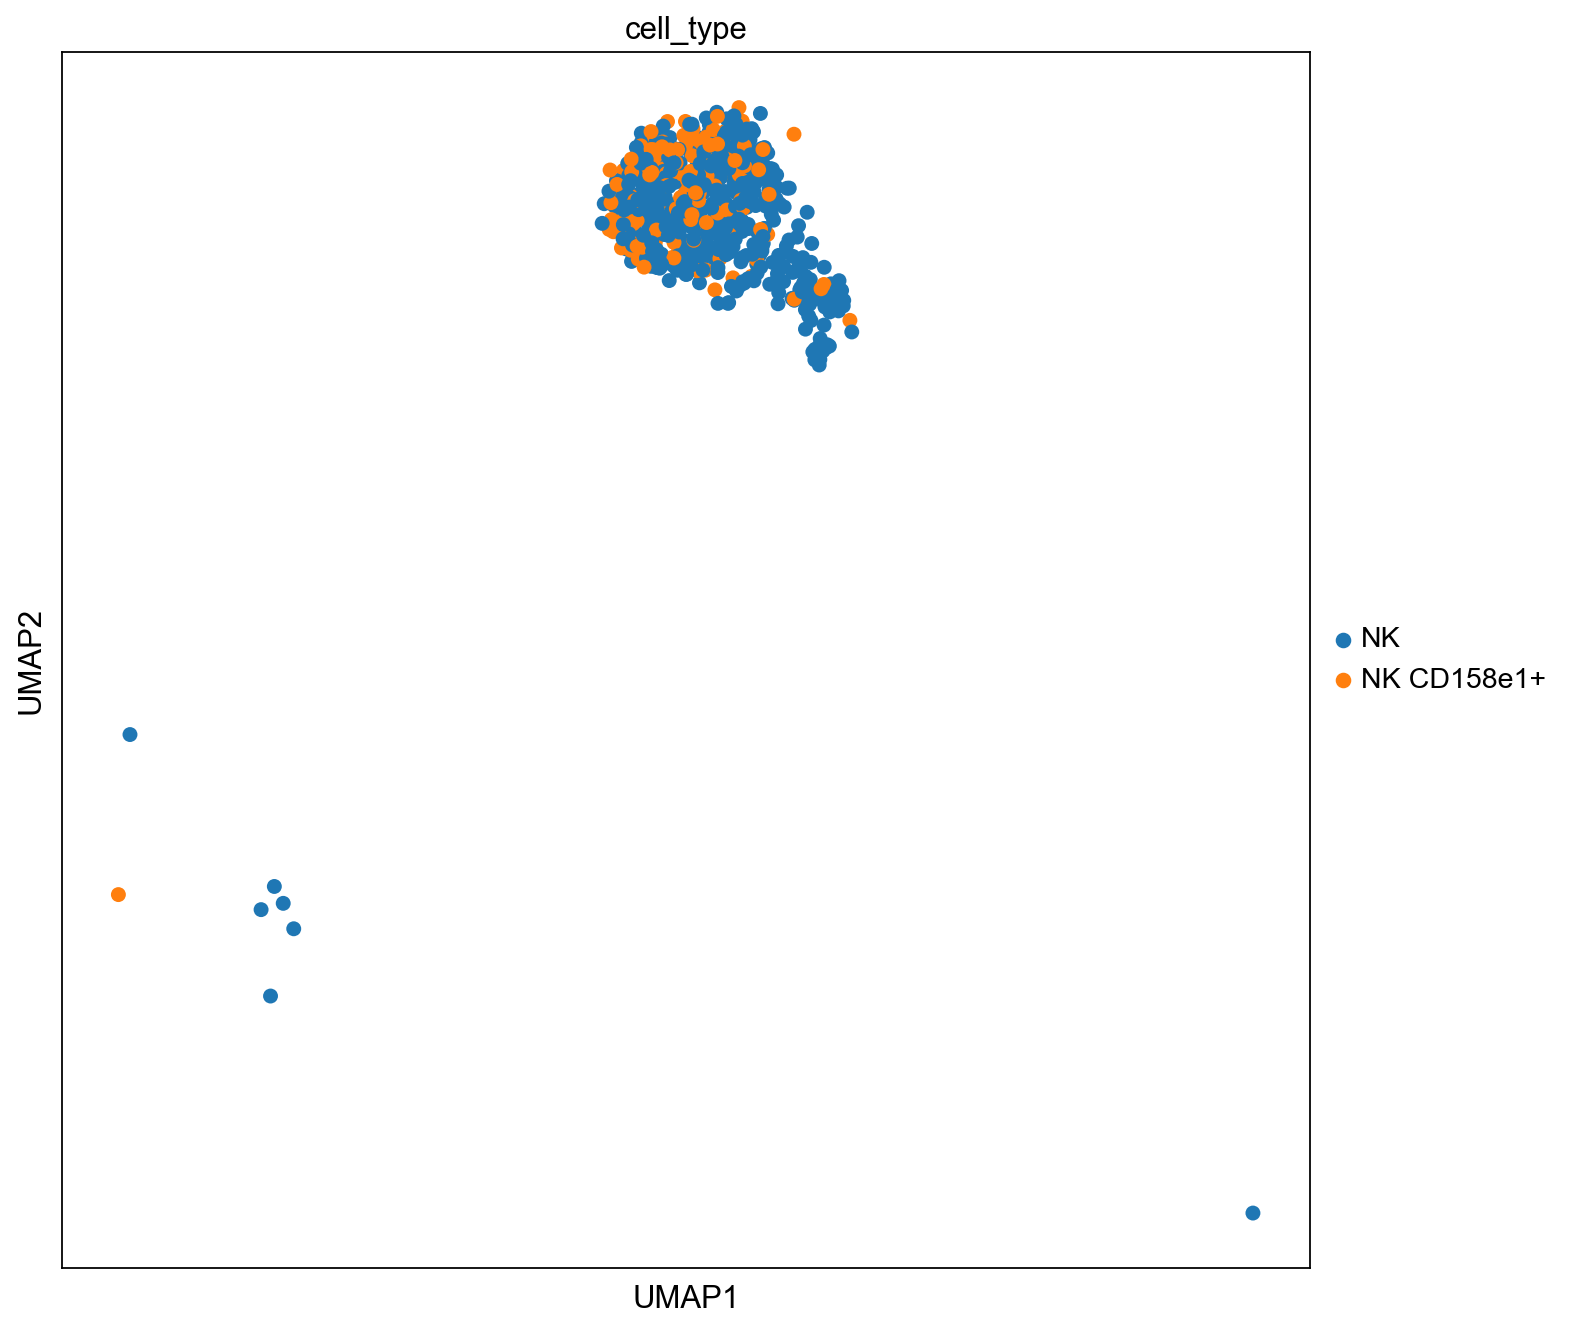

In [17]:
#NK, gd T cells and ILCs from selected sample

sc.pl.umap(sample_nk, color = ['cell_type'], color_map = 'viridis')

In [18]:
#selecting one sample from Neurips

eg=adata_neurips[adata_neurips.obs['POOL'] == "s4d1"]

In [19]:
#Computing a neighborhood of observations using latent space, before subsetting the data

sc.pp.neighbors(sample_nk, use_rep="X_totalVI")   #indicated representation

sc.tl.umap(sample_nk)

In [20]:
sample_nk

AnnData object with n_obs × n_vars = 665 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44_prot', 'CD14', 'CD16', 'CD25', 

## Markers by Melsen et al.

- scRNA-seq on bone marrow. 
- CD56, CXCR6, CD117 and CD34 oligonucleotide-conjugated antibodies were used
- healthy donors, 1 BM transplant recipient


### 8 NK cell cluster were defined: #

1. Mature CD56dim NK cells (83% of all cells)
2. lymhphoid tissue-resident (lt) CXCR6+ NK cells (4%) 
3. CD34+ (progenitors?) (1.9%)
4. immature CD56bright NK cells (
5. non-cytotoxic innate lymphoid cells (ILCs)
6. proliferating NK cells
7. Mature CD56dim NK cells (3.4% of all cells)
8. CD56- and CD16+ NK cells with reduced effector function


### Markers: #

1. GZMK-, S100A4, S100A6, ACTB, ACTG1, CORO1A, PFN1. 
2. CCL3, CCL4, XCL1, GZMK, CD160, DUSP2, CXCR4, BTG1
3. Mainly defined by absence of CCL5, CD117+
4. SELL (CD62L), CD2, CD117, IL7R, high expression of KLRC1, CD56bright
5. Absence of NKG7, high expression of IL7R, high expression of FGFBP2, PRSS23
6. Upregulated cell cycle genes, high S100A4, S100A6, KLRC2. Upregulation of IL32, GZMH and GNLY, and downregulation of KLRC1, KLRB1 (CD161) and CD160
7. GZMK+, higher expression of SELL (CD62L) and lower expression of GZMB, PRF1 and PCGR3A (CD16) compared to cluster 1. Intermediate stage between CD56bright and CD56dim? 
8. Express NKG7 and FCGR3A, but had low expression of PRF1 and GZMB. CD56-, CD16+. 


- Generally, inhibitory KIRs more frequently expressed in terminally differentiated cells, but in this study were not in top5 DE genes. 
- When comparing to other datasets,  CD56- NK cells not found (probably donor specific). The CD34+ and ltNK cells were barely detected in blood (likely bone-marrow resident). 
- New identified cluster 2, CD56dim GZMK+. Likely intermediate state between CD56bright and CD56dim
- pseudotime analysis of terminally differentiated cells : FGFBP2, PRF1,GZMB, GZMK. Shift from granzyme K to granzyme B during differentiation. 

In [22]:
#Used to check which markers were measured


#listOfmarkers= ['CD160']


#for x in listOfmarkers:
#    if x in prot.columns:
#        print(x)


# Protein vs RNA

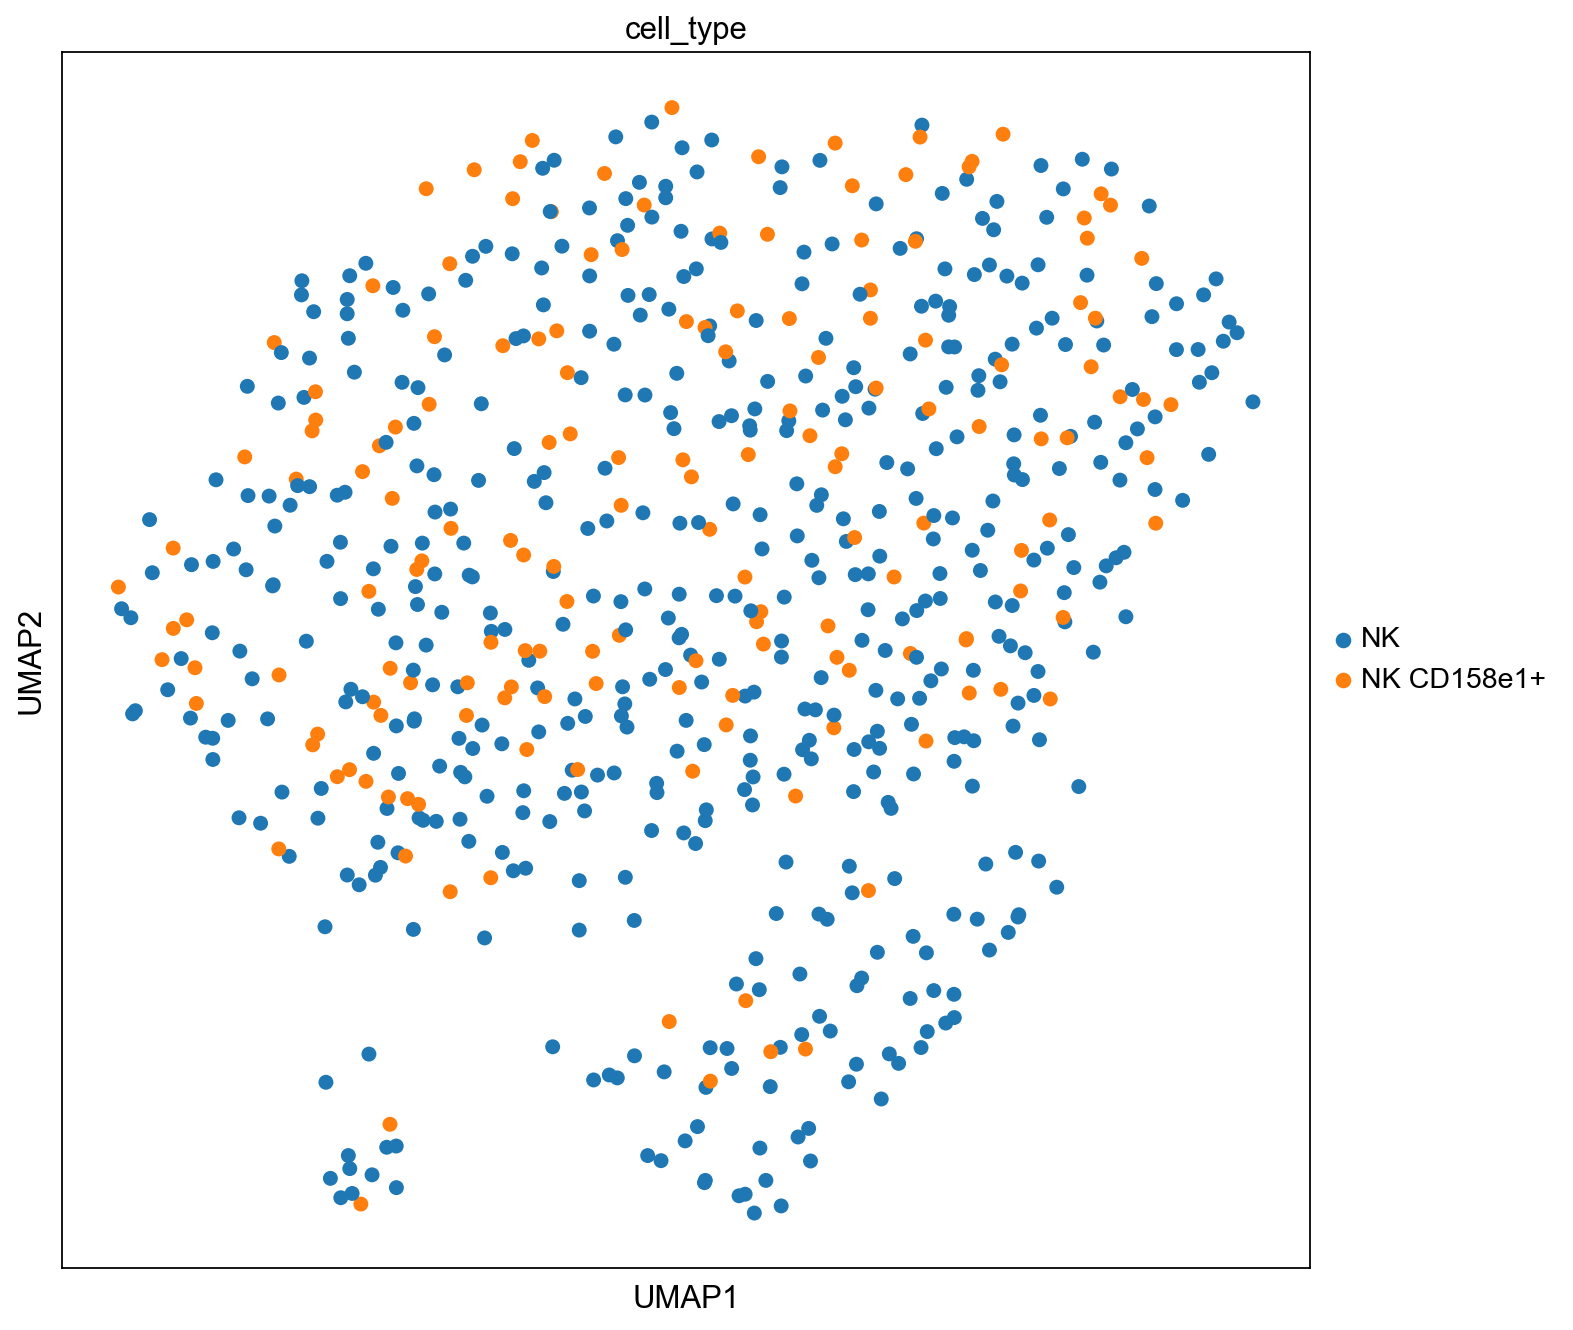

lymphoid tissue-resident NK cells, RNA


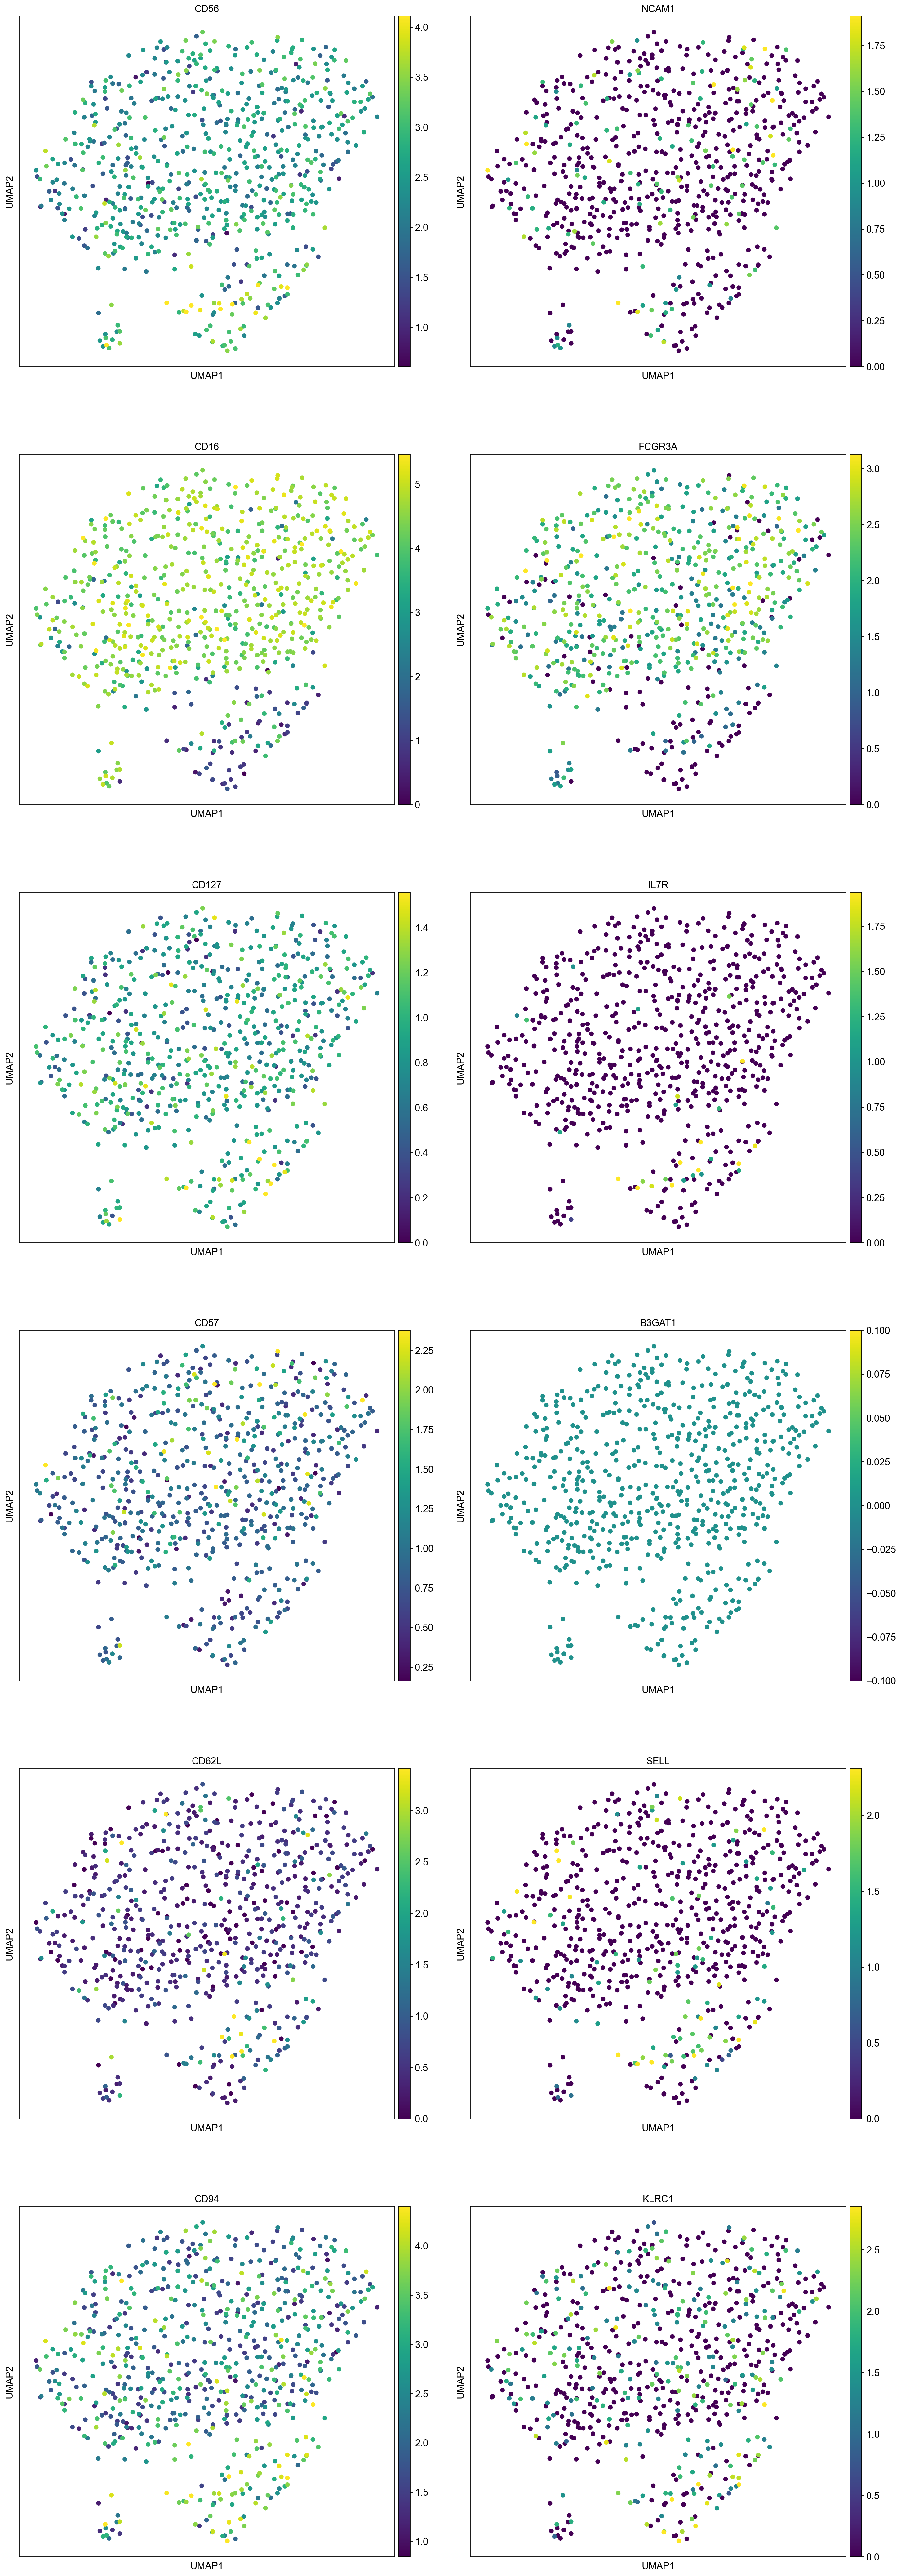

In [21]:
markers= ['CD56', 'NCAM1', 'CD16','FCGR3A', 'CD127', 'IL7R', 'CD57', 'B3GAT1', 'CD62L','SELL', 'CD94', 'KLRC1']

sc.pl.umap(sample_nk, color = ['cell_type'], color_map = 'viridis')

#RNA
print('lymphoid tissue-resident NK cells, RNA')
sc.pl.umap(sample_nk, color = markers, vmax="p99", color_map = 'viridis', ncols=2)


In [ ]:

sc.pl.umap(eg, color = ['cell_type'], color_map = 'viridis')

#RNA
print('lymphoid tissue-resident, RNA')
sc.pl.umap(eg, color = tr_mels, vmax="p99", color_map = 'viridis', ncols=2)


- based on these markers difficult to evaluate the localization of the lt-NK cells on the UMAP. 

## 3. Non-cytotoxic innate lymphoid cells (ILCs, cluster 5 in the paper) 

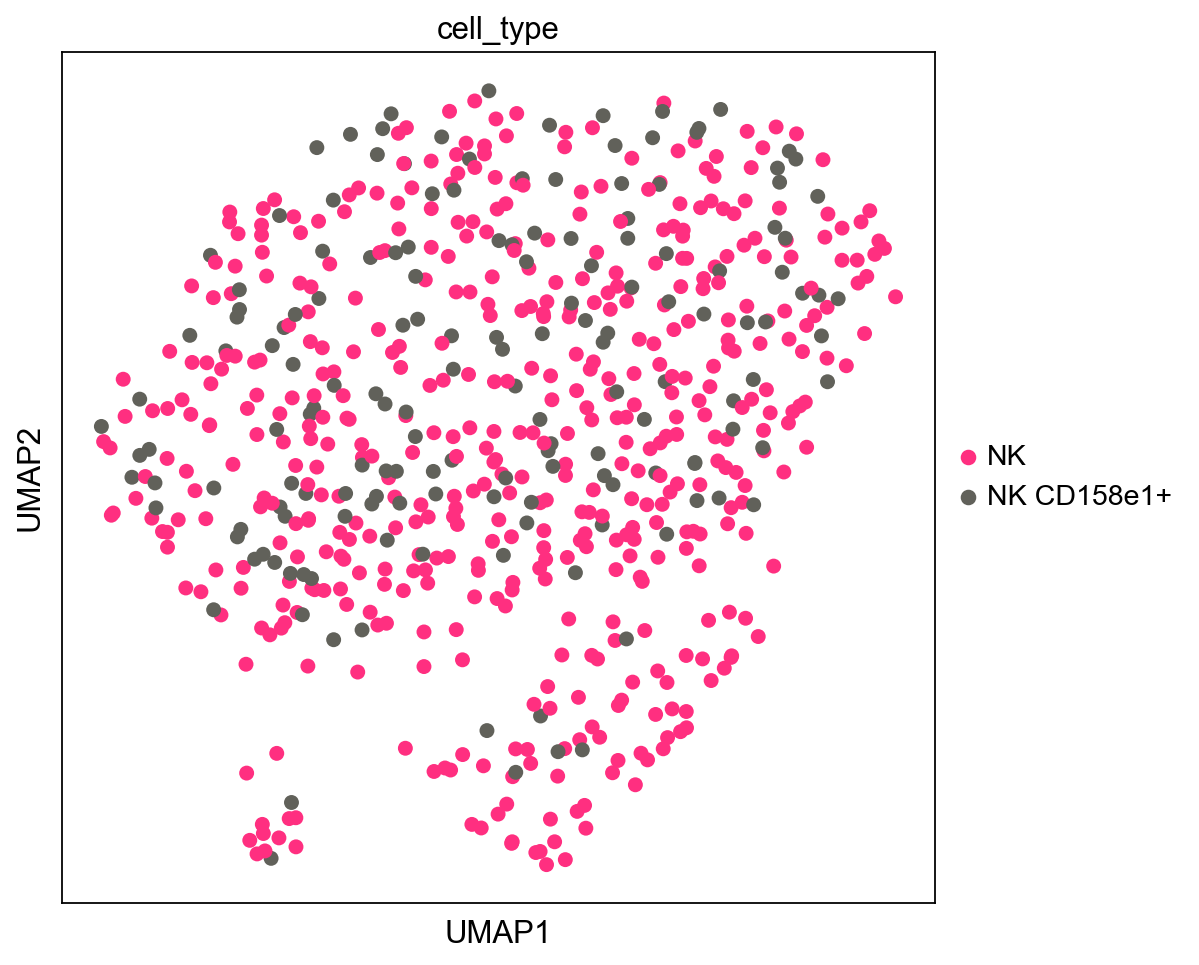

ILC, high expression, RNA


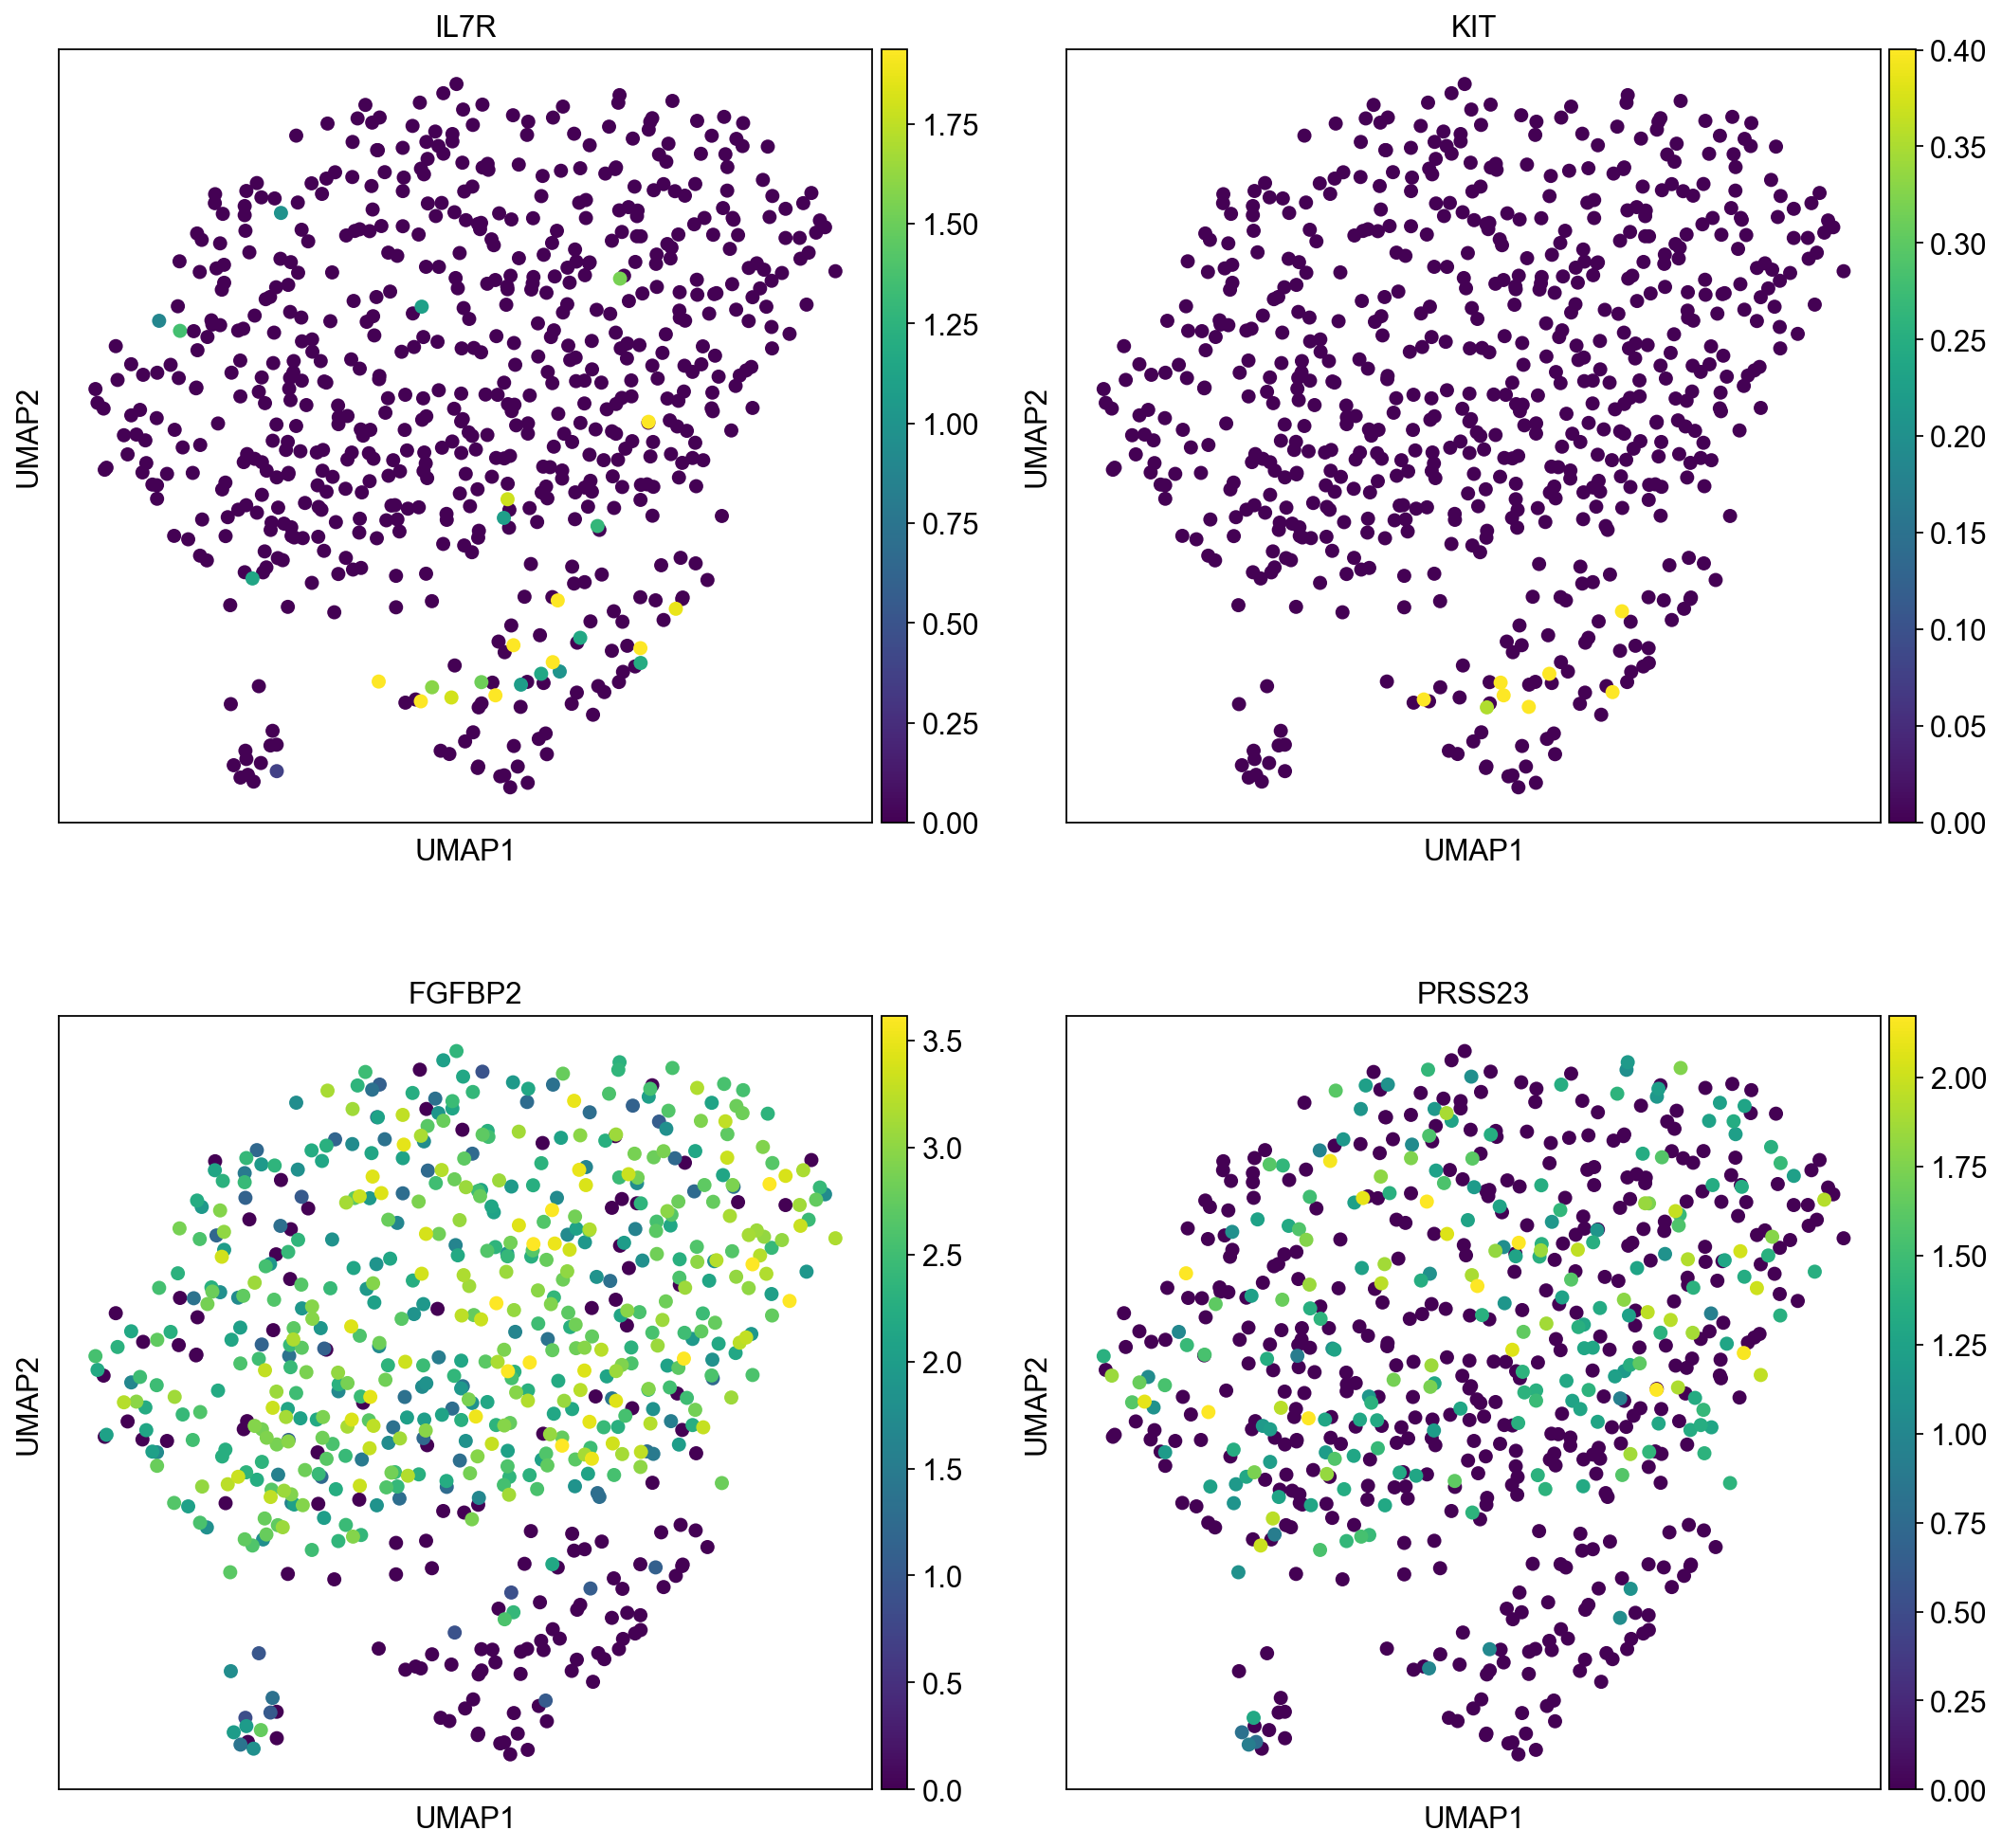

ILC, low expression


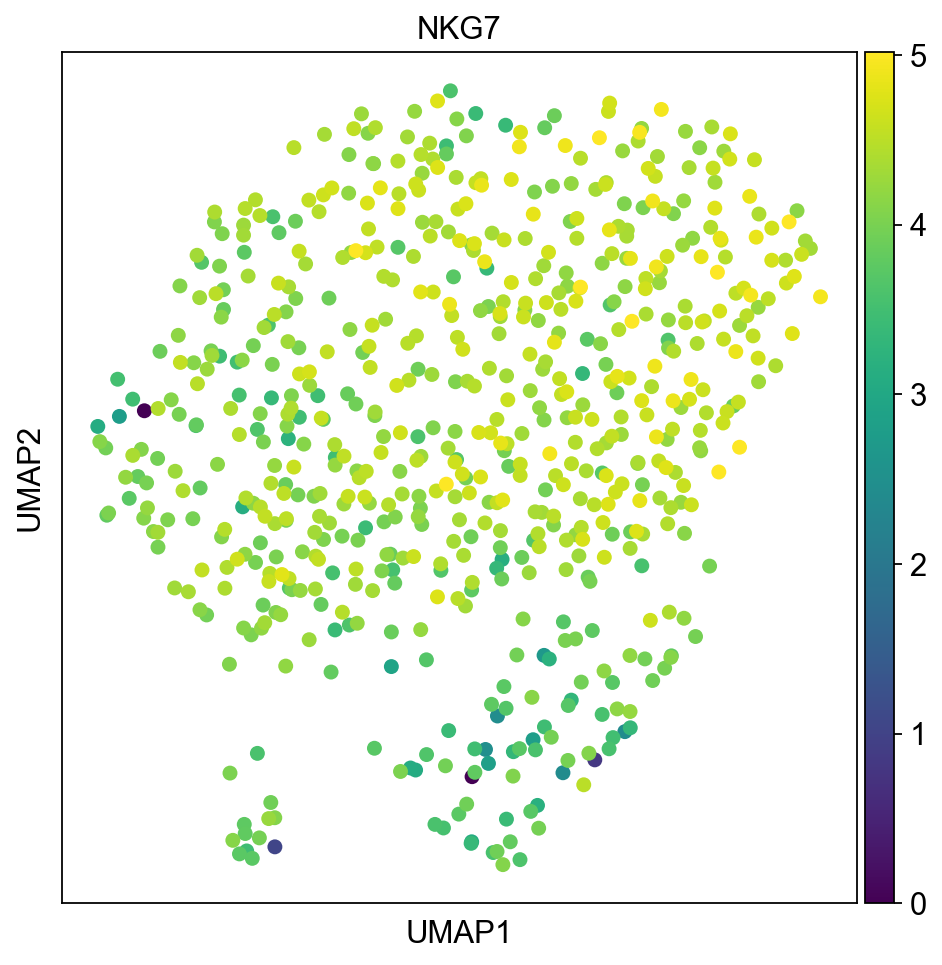

In [64]:
ILC_mels_high = ['IL7R', 'KIT', 'FGFBP2', 'PRSS23'] 
ILC_mels_low = ['NKG7']

#KIT = CD117 (not included in antibody panel)

sc.set_figure_params(figsize=(7, 7))

sc.pl.umap(sample_nk, color = ['cell_type'], color_map = 'viridis')

#RNA
print("ILC, high expression, RNA")
sc.pl.umap(sample_nk, color = ILC_mels_high, vmax="p99", color_map = 'viridis', ncols=2)

print("ILC, low expression")
sc.pl.umap(sample_nk, color = ILC_mels_low, vmax="p99", color_map = 'viridis', ncols=2)

